In [15]:
import cv2
import matplotlib.pyplot as plt
import os
from pathlib import Path
import numpy as np
import yaml
import random

from general_utils.files_utils import DirectoryUtils, FileUtils
abs_path = DirectoryUtils.getRosPkgPath('create_dataset')

In [16]:
objects_list = ["000_cereal_box_UO", "001_chips_can",
"002_master_chef_can", "003_cracker_box", "004_sugar_box",
"005_tomato_soup_can", "006_mustard_bottle", "007_tuna_fish_can", "008_pudding_box",
"009_gelatin_box", "010_potted_meat_can", "011_banana", "012_strawberry", "013_apple",
"014_lemon", "015_peach", "016_pear", "017_orange", "018_plum", "019_pitcher_base",
"021_bleach_cleanser", "024_bowl", "025_mug", "026_sponge", "027_skillet", "029_plate",
"030_fork", "031_spoon", "032_knife", "033_spatula", "035_power_drill", "036_wood_block",
"037_scissors", "038_padlock", "040_large_marker", "042_adjustable_wrench",
"043_phillips_screwdriver", "044_flat_screwdriver", "048_hammer", "050_medium_clamp",
"051_large_clamp", "052_extra_large_clamp", "053_mini_soccer_ball", "054_softball",
"055_baseball", "056_tennis_ball", "057_racquetball", "058_golf_ball", "059_chain",
"061_foam_brick", "062_dice", "063-a_marbles", "063-b_marbles", "065-a_cups",
"065-b_cups", "065-c_cups", "065-d_cups", "065-e_cups", "065-f_cups", "065-g_cups",
"065-h_cups", "065-i_cups", "065-j_cups", "070-a_colored_wood_blocks", "070-b_colored_wood_blocks",
"071_nine_hole_peg_test", "072-a_toy_airplane", "072-b_toy_airplane", "072-c_toy_airplane",
"072-d_toy_airplane", "072-e_toy_airplane", "073-a_lego_duplo", "073-b_lego_duplo",
"073-c_lego_duplo", "073-d_lego_duplo", "073-e_lego_duplo", "073-f_lego_duplo", 
"073-g_lego_duplo", "077_rubiks_cube"]

objects_dictionary = {}
for i, object in enumerate(objects_list):
    objects_dictionary.update({i:object})

# for key, val in objects_dictionary.items():
#     print(key, "\t\t", val)
    
dataset_name = "YCB_virtual"
data_set_path = os.path.join(abs_path, dataset_name)
data_set_images_path = os.path.join(data_set_path, "images")
data_set_labels_path = os.path.join(data_set_path, "labels")
print("objects: ", len(objects_list))
print(data_set_path)
print(data_set_images_path)
print(data_set_labels_path)

objects:  79
/home/devan/GIT/Juskeshino/catkin_ws/src/mapless_navigation/create_dataset/YCB_virtual
/home/devan/GIT/Juskeshino/catkin_ws/src/mapless_navigation/create_dataset/YCB_virtual/images
/home/devan/GIT/Juskeshino/catkin_ws/src/mapless_navigation/create_dataset/YCB_virtual/labels


In [17]:
def write_yaml_data(strings, file_name='dataset_name'):
    file_path = os.getcwd() + "/" + file_name + ".yaml"
    print(file_path)

    with open(file_path, 'w') as file:
        msg = {'pat':'../datasets/'+dataset_name,
               'train':'images/train',
               'val':'images/val'}
        #file.write('# Autor: Daniel Vanegas\n')
        yaml.dump(msg, file, sort_keys=False)
        file.write('test:\n\n')
        
        yaml.dump({'names':objects_dictionary}, file, sort_keys=False)

write_yaml_data(1, dataset_name)

/home/devan/GIT/Juskeshino/catkin_ws/src/mapless_navigation/create_dataset/scripts/YCB_virtual.yaml


In [18]:
# Source images path
source_images_path = os.path.join(abs_path, "Source_images")
print("source_images_path")
print(source_images_path)
print()
# Replace directory
DirectoryUtils.replaceDir(data_set_path, verbose=True)
DirectoryUtils.createDir(data_set_images_path, verbose=True)
DirectoryUtils.createDir(data_set_labels_path, verbose=True)

source_images_path
/home/devan/GIT/Juskeshino/catkin_ws/src/mapless_navigation/create_dataset/Source_images

rmdir:  /home/devan/GIT/Juskeshino/catkin_ws/src/mapless_navigation/create_dataset/YCB_virtual
Verifying if directory path exist...
Directory deleted
Directory created
Directory successful replaced
make dirs:  /home/devan/GIT/Juskeshino/catkin_ws/src/mapless_navigation/create_dataset/YCB_virtual/images
Verifying if directory path exist...
Directory created
make dirs:  /home/devan/GIT/Juskeshino/catkin_ws/src/mapless_navigation/create_dataset/YCB_virtual/labels
Verifying if directory path exist...
Directory created


True

In [19]:
def box_xywh_to_points(x, y, w, h):
    return (x, y), (x+w, y+h)


def box_points_to_xywh(p1, p2):
    x, y = p1[0], p1[1]
    w = p2[0] - x
    h = p2[1] - y
    return x, y, w, h


def center_point(p1, p2):
    c_x = p1[0] + (p2[0]-p1[0])/2
    c_y = p1[1] + (p2[1]-p1[1])/2   
    if isinstance(p1[0], int):        
        return (int(c_x), int(c_y))
    else:
        return (c_x, c_y)


def box_pixel_to_prop(p1, p2, shape=(1, 1)):
    x_shape, y_shape = shape
    c_x, c_y = center_point(p1, p2)
    _, _, w, h = box_points_to_xywh(p1, p2)
    cx_prop = c_x / x_shape
    cy_prop = c_y / y_shape
    w_prop = w / x_shape
    h_prop = h / y_shape
    return ((cx_prop, cy_prop), w_prop, h_prop)


def box_prop_to_pixel(c_prop, w_prop, h_prop, shape=(1, 1)):
    x_shape, y_shape = shape
    cx_prop, cy_prop = c_prop
    w = int(w_prop * x_shape)
    h = int(h_prop * y_shape)
    c_x = cx_prop * x_shape 
    c_y = cy_prop * y_shape
    x = int(c_x - w/2)
    y = int(c_y - h/2)
    p1, p2 =  box_xywh_to_points(x, y, w, h)
    return (p1, p2)

In [20]:
def boxes_from_mask(img, format="points"):
    """
    format:
    
    'xywh'      return x, y, w, h

    'points'    return (p1, p2)

    'yolov5'    return ((x_prop_center, y_prop_center), w_prop, h_prop)
    """
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)  # convert to grayscale
    thresh = cv2.threshold(gray, 8, 255, cv2.THRESH_BINARY)[1]  # threshold
    # get contours
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    boxes = []
    x_shape, y_shape, _ = img.shape
    for cntr in contours:
        x, y, w, h = cv2.boundingRect(cntr)
        p1, p2 = box_xywh_to_points(x, y, w, h)

        if format == "xywh":
            boxes.append((x, y, w, h))
        
        elif format == "points":
            boxes.append((p1, p2))

        elif format == "yolov5":
            cp, wp, hp = box_pixel_to_prop(p1, p2, (x_shape, y_shape))
            boxes.append((cp, wp, hp))

        else:
            print("Error! arg 'format' must be: 'xywh', 'points' or 'yolov5'")
            return(None)

    return boxes

{'000_cereal_box_UO': 0, '001_chips_can': 1, '002_master_chef_can': 2, '003_cracker_box': 3, '004_sugar_box': 4, '005_tomato_soup_can': 5, '006_mustard_bottle': 6, '007_tuna_fish_can': 7, '008_pudding_box': 8, '009_gelatin_box': 9, '010_potted_meat_can': 10, '011_banana': 11, '012_strawberry': 12, '013_apple': 13, '014_lemon': 14, '015_peach': 15, '016_pear': 16, '017_orange': 17, '018_plum': 18, '019_pitcher_base': 19, '021_bleach_cleanser': 20, '024_bowl': 21, '025_mug': 22, '026_sponge': 23, '027_skillet': 24, '029_plate': 25, '030_fork': 26, '031_spoon': 27, '032_knife': 28, '033_spatula': 29, '035_power_drill': 30, '036_wood_block': 31, '037_scissors': 32, '038_padlock': 33, '040_large_marker': 34, '042_adjustable_wrench': 35, '043_phillips_screwdriver': 36, '044_flat_screwdriver': 37, '048_hammer': 38, '050_medium_clamp': 39, '051_large_clamp': 40, '052_extra_large_clamp': 41, '053_mini_soccer_ball': 42, '054_softball': 43, '055_baseball': 44, '056_tennis_ball': 45, '057_racquetb

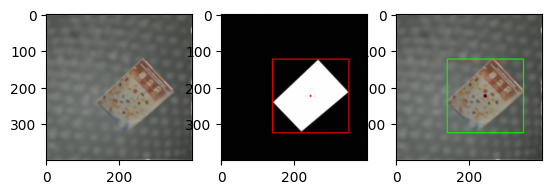

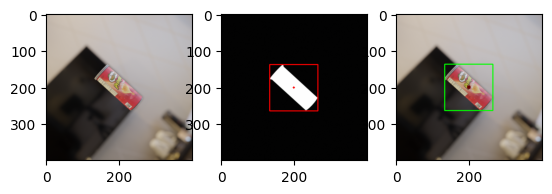

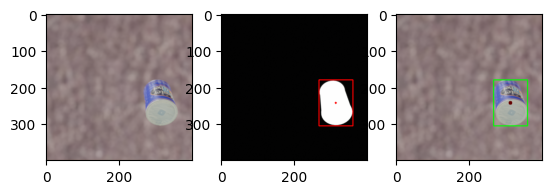

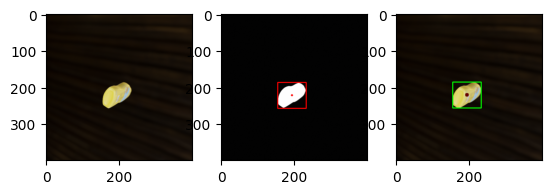

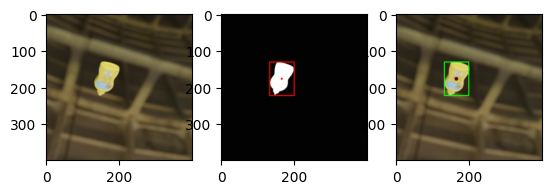

In [21]:
import glob

invert_dictionary = dict(zip(objects_dictionary.values(), objects_dictionary.keys()))
print(invert_dictionary)

files_to_write = []
for object_name in objects_list:
    ob_list = glob.glob(source_images_path + "/" + object_name + "*[!_mask].*")
    ob_list.sort()
    count=0

    for file_name in ob_list:
        print("--file:", file_name.split('/')[-1])
        key = object_name  # dictionary key
        
        img = FileUtils.loadImage(file_name)
        if img is None:
            print("No image found:")
        mask_path, _, extension = file_name.partition('.')
        mask_path += "_mask." + extension
        mask_img = FileUtils.loadImage(mask_path)
        mask_img = cv2.bitwise_not(mask_img)

        boxes = boxes_from_mask(mask_img)
        # TODO: loop for multiple boxes
        box = boxes[0]
        print(img.shape)
        print("Box:", box)
        result = mask_img.copy()
        cv2.rectangle(result, box[0], box[1], (255, 0, 0), 2)
        #cv2.circle(result, center_coordinates, radius, color, thickness)
        center = center_point(box[0], box[1])
        cv2.circle(result, center, 1, (255, 0, 0), 3)

        # Validate proportional rect in plot 3
        prop_img = img.copy()
        x_shape, y_shape, _ = prop_img.shape
        c_p, w_p, h_p = boxes_from_mask(mask_img, format="yolov5")[0]
        p1, p2 = box_prop_to_pixel(c_p, w_p, h_p, shape=(x_shape, y_shape))
        cv2.rectangle(prop_img, p1, p2, (0, 255, 0), 2)
        center_2 = center_point(p1, p2)
        cv2.circle(prop_img, center_2, 1, (100, 0, 0), 8)

        f, axarr = plt.subplots(1,3)
        axarr[0].imshow(img)
        axarr[1].imshow(result)
        axarr[2].imshow(prop_img)
        count += 1

        # Save label
        # Each row is: class x_center y_center width height
        class_type = invert_dictionary[key]
        label = str(class_type) + ' ' + str(c_p[0]) + ' ' + str(c_p[1]) + ' ' +\
                str(w_p) + ' ' + str(h_p)
        print("file:", file_name)
        print("label:", label)
        files_to_write.append((file_name, label))

    if count > 0:
        print()
       

In [28]:
#data_set_images_path
#data_set_labels_path

import shutil

DirectoryUtils.replaceDir
def write_files(files_to_write, randomize=False, rename=False, base_name='', train_split=1.0):
    new_name = []
    
    DirectoryUtils.replaceDir(os.path.join(data_set_images_path, "train"))
    DirectoryUtils.replaceDir(os.path.join(data_set_images_path, "val"))
    DirectoryUtils.replaceDir(os.path.join(data_set_labels_path, "train"))
    DirectoryUtils.replaceDir(os.path.join(data_set_labels_path, "val"))


    min_percent = 1 / len(files_to_write)
    if train_split > 1.0 or train_split < min_percent:
        print("Error! bad split proportion on 'train_split' value, must be in range (", min_percent, ", 1.0 )")
        print("Your dataset length is:", len(files_to_write))
        print("One image in your data represents", min_percent)
        return None

    if randomize:
        random.shuffle(files_to_write)

    if rename:
        zeros = len(str(len(files_to_write)))
        for i, file in enumerate(files_to_write):
            index = base_name + str(i).zfill(zeros)
            new_name.append(index)
            #print(index, file)

    val_train_folder = "train"
    for i, file in enumerate(files_to_write):
        print(file)
        percent = (i+1) /len(files_to_write)
        print(percent*100, "%")
        orig_name = file[0].split('/')[-1]
        src = file[0]
    
        print(orig_name)
        print("src:", src)

        if percent > train_split:
            # File is destined to validation
            val_train_folder = "val"

        if rename:
            ext = '.'+ orig_name.split('.')[-1]
            dst = os.path.join(data_set_images_path, val_train_folder, new_name[i] + ext)
            label_name = new_name[i] + ".txt"
        else:
            dst = os.path.join(data_set_images_path, val_train_folder, orig_name)
            label_name = orig_name.split('.')[0] + ".txt"

        print("dst:", dst)
        
        label_file = os.path.join(data_set_labels_path, val_train_folder, label_name)
        print("label:", label_file)

        # Copy-Write files
        shutil.copyfile(src, dst)
        label = file[1]
        with open(label_file, 'w') as file:
            # TODO: implement multi labels
            file.write(label)

        print()
      
        


In [30]:
write_files(files_to_write, randomize=True, rename=False, \
            base_name="image_", train_split=0.8)

Directory created
Directory created
Directory created
Directory created
('/home/devan/GIT/Juskeshino/catkin_ws/src/mapless_navigation/create_dataset/Source_images/006_mustard_bottle-01.png', '6 0.485 0.555 0.195 0.1775')
20.0 %
006_mustard_bottle-01.png
src: /home/devan/GIT/Juskeshino/catkin_ws/src/mapless_navigation/create_dataset/Source_images/006_mustard_bottle-01.png
dst: /home/devan/GIT/Juskeshino/catkin_ws/src/mapless_navigation/create_dataset/YCB_virtual/images/train/006_mustard_bottle-01.png
label: /home/devan/GIT/Juskeshino/catkin_ws/src/mapless_navigation/create_dataset/YCB_virtual/labels/train/006_mustard_bottle-01.txt

('/home/devan/GIT/Juskeshino/catkin_ws/src/mapless_navigation/create_dataset/Source_images/006_mustard_bottle-02.png', '6 0.415 0.4425 0.1675 0.23')
40.0 %
006_mustard_bottle-02.png
src: /home/devan/GIT/Juskeshino/catkin_ws/src/mapless_navigation/create_dataset/Source_images/006_mustard_bottle-02.png
dst: /home/devan/GIT/Juskeshino/catkin_ws/src/mapless_navig

### Visualize labels

In [ ]:
def label_image(img, box, name=""):
    print(name)
    

# -------------------


In [ ]:
resized_img = FileUtils.resizeImage(img, 200)
print(resized_img.shape)
plt.imshow(resized_img)